# Cleaning Data in Python


## Importing the data


In [36]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt

In [37]:
df_ride = pd.read_csv("../data/ride_sharing_new.csv")
df_ridev2 = pd.read_csv("../data/ride_sharing_new_v2.csv", sep=";")
height_weight = pd.read_csv("../data/height_weight.csv", sep=";", index_col=0)
airlines = pd.read_csv("../data/airlines_final.csv", index_col=0)
categories = pd.read_csv("../data/categories.csv", index_col=0, sep=";")
banking = pd.read_csv("../data/banking.csv", index_col=0, sep=";")
restaurants = pd.read_csv("../data/restaurants_L2_dirty.csv", index_col=0)
restaurants_new = pd.read_csv("../data/restaurants_L2.csv", index_col=0)

## 1. Common data problems


### Data type constraints


In [38]:
df_ride.dtypes

Unnamed: 0          int64
duration           object
station_A_id        int64
station_A_name     object
station_B_id        int64
station_B_name     object
bike_id             int64
user_type           int64
user_birth_year     int64
user_gender        object
dtype: object

In [39]:
df_ride.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25760 entries, 0 to 25759
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Unnamed: 0       25760 non-null  int64 
 1   duration         25760 non-null  object
 2   station_A_id     25760 non-null  int64 
 3   station_A_name   25760 non-null  object
 4   station_B_id     25760 non-null  int64 
 5   station_B_name   25760 non-null  object
 6   bike_id          25760 non-null  int64 
 7   user_type        25760 non-null  int64 
 8   user_birth_year  25760 non-null  int64 
 9   user_gender      25760 non-null  object
dtypes: int64(6), object(4)
memory usage: 2.0+ MB


In [40]:
df_ride["user_type"].describe()

count    25760.000000
mean         2.008385
std          0.704541
min          1.000000
25%          2.000000
50%          2.000000
75%          3.000000
max          3.000000
Name: user_type, dtype: float64

In [41]:
df_ride["user_type_cat"] = df_ride["user_type"].astype("category")

assert df_ride["user_type_cat"].dtype == "category"
df_ride["user_type_cat"].describe()

count     25760
unique        3
top           2
freq      12972
Name: user_type_cat, dtype: int64

In [42]:
df_ride["duration_trim"] = df_ride["duration"].str.strip("minutes").astype("int")

assert df_ride["duration_trim"].dtype == "int"
df_ride["duration_trim"].mean()

11.389052795031056

### Data range constraints


In [43]:
df_ridev2["tire_sizes"] = df_ridev2["tire_sizes"].astype("int")
df_ridev2.loc[df_ridev2["tire_sizes"] > 27, "tire_sizes"] = 27
df_ridev2["tire_sizes"] = df_ridev2["tire_sizes"].astype("category")

df_ridev2["tire_sizes"].describe()

count     20
unique     2
top       26
freq      10
Name: tire_sizes, dtype: int64

In [50]:
import datetime as dt

df_ridev2["ride_dt"] = pd.to_datetime(df_ridev2["ride_date"], dayfirst=True)

today = dt.date.today()
df_ridev2.loc[df_ridev2["ride_dt"] > pd.to_datetime(today), "ride_date"] = today
print(df_ridev2["ride_dt"].max())

2022-05-17 00:00:00


### Uniqueness constraints


In [51]:
height_weight.head()

,first_name,last_name,height,weight
0,Lane,Reese,181,64
1,Ivor,Pierce,168,66
2,Roary,Gibson,191,99
3,Shannon,Little,185,65
4,Abdul,Fry,169,65


In [52]:
duplicates = height_weight.duplicated(subset=["first_name", "last_name"], keep=False)
height_weight[duplicates].sort_values("first_name")

,first_name,last_name,height,weight
22,Cole,Palmer,178,91
102,Cole,Palmer,178,91
28,Desirae,Shannon,195,83
103,Desirae,Shannon,196,83
1,Ivor,Pierce,168,66
101,Ivor,Pierce,168,88
37,Mary,Colon,179,75
100,Mary,Colon,179,75


In [53]:
height_weight.drop_duplicates(inplace=True)
height_weight.head()

,first_name,last_name,height,weight
0,Lane,Reese,181,64
1,Ivor,Pierce,168,66
2,Roary,Gibson,191,99
3,Shannon,Little,185,65
4,Abdul,Fry,169,65


In [55]:
column_names = ['first_name','last_name']
summaries = {'height': 'max','weight': 'mean'}
height_weight = height_weight.groupby(by = column_names).agg(summaries).reset_index()
duplicates = height_weight.duplicated(subset = column_names, keep = False)
height_weight[duplicates].sort_values(by = 'first_name')

,first_name,last_name,height,weight


## 2.Text and categorical data problems

### Membership constraints

In [56]:
airlines.head(2)

,id,day,airline,destination,dest_region,dest_size,boarding_area,dept_time,wait_min,cleanliness,safety,satisfaction
0,1351,Tuesday,UNITED INTL,KANSAI,Asia,Hub,Gates 91-102,2018-12-31,115.0,Clean,Neutral,Very satisfied
1,373,Friday,ALASKA,SAN JOSE DEL CABO,Canada/Mexico,Small,Gates 50-59,2018-12-31,135.0,Clean,Very safe,Very satisfied


In [57]:
print('Cleanliness: ', airlines["cleanliness"].unique())

Cleanliness:  ['Clean' 'Average' 'Somewhat clean' 'Somewhat dirty' 'Dirty']


In [64]:
cat_clean = set(airlines["cleanliness"]).difference(categories['cleanliness'])
cat_clean_rows = airlines['cleanliness'].isin(cat_clean)
print(airlines[cat_clean_rows])

Empty DataFrame
Columns: [id, day, airline, destination, dest_region, dest_size, boarding_area, dept_time, wait_min, cleanliness, safety, satisfaction]
Index: []


### Categorical variables

In [67]:
print(airlines["dest_region"].unique())
print(airlines["dest_size"].unique())

airlines["dest_region"] = airlines["dest_region"].str.lower()
airlines["dest_region"] = airlines["dest_region"].replace({"eur": "europe"})

['asia' 'canada/mexico' 'west us' 'east us' 'midwest us' 'middle east'
 'europe' 'central/south america' 'australia/new zealand']
['Hub' 'Small' '    Hub' 'Medium' 'Large' 'Hub     ' '    Small'
 'Medium     ' '    Medium' 'Small     ' '    Large' 'Large     ']


In [71]:
airlines['dest_size'] = airlines['dest_size'].str.strip()

print(airlines["dest_region"].unique())
print(airlines["dest_size"].unique())

['asia' 'canada/mexico' 'west us' 'east us' 'midwest us' 'middle east'
 'europe' 'central/south america' 'australia/new zealand']
['Hub' 'Small' 'Medium' 'Large']


### Remapping categories

In [77]:
label_ranges = [0, 60, 180, np.inf]
label_names = ["short", "medium", "long"]

airlines["wait_type"] = pd.cut(
    airlines["wait_min"], bins=label_ranges, labels=label_names
)

mappings = {
    "Monday": "weekday",
    "Tuesday": "weekday",
    "Wednesday": "weekday",
    "Thursday": "weekday",
    "Friday": "weekday",
    "Saturday": "weekend",
    "Sunday": "weekend",
}

airlines['day_week'] = airlines['day'].replace(mappings)

airlines.head()

,id,day,airline,destination,dest_region,dest_size,boarding_area,dept_time,wait_min,cleanliness,safety,satisfaction,wait_type,day_week
0,1351,Tuesday,UNITED INTL,KANSAI,asia,Hub,Gates 91-102,2018-12-31,115.0,Clean,Neutral,Very satisfied,medium,weekday
1,373,Friday,ALASKA,SAN JOSE DEL CABO,canada/mexico,Small,Gates 50-59,2018-12-31,135.0,Clean,Very safe,Very satisfied,medium,weekday
2,2820,Thursday,DELTA,LOS ANGELES,west us,Hub,Gates 40-48,2018-12-31,70.0,Average,Somewhat safe,Neutral,medium,weekday
3,1157,Tuesday,SOUTHWEST,LOS ANGELES,west us,Hub,Gates 20-39,2018-12-31,190.0,Clean,Very safe,Somewhat satsified,long,weekday
4,2992,Wednesday,AMERICAN,MIAMI,east us,Hub,Gates 50-59,2018-12-31,559.0,Somewhat clean,Very safe,Somewhat satsified,long,weekday


## 3. Advanced data problems

### Uniformity

In [89]:
acct_eu = banking['acct_cur'] == 'euro'
banking.loc[acct_eu, 'acct_amount'] = banking.loc[acct_eu, 'acct_amount'] * 1.1
banking.loc[acct_eu, 'acct_cur'] = 'dollar'
assert banking['acct_cur'].unique() == 'dollar'

In [92]:
print(banking["account_opened"].head())

banking["account_opened"] = pd.to_datetime(
    banking["account_opened"], infer_datetime_format=True, errors="coerce"
)

banking['acct_year'] = banking['account_opened'].dt.strftime("%Y")

print(banking["acct_year"].head())

0   2018-03-05
1          NaT
2          NaT
3          NaT
4   2017-05-06
Name: account_opened, dtype: datetime64[ns]
0    2018
1     NaN
2     NaN
3     NaN
4    2017
Name: acct_year, dtype: object


C:\Users\theki\AppData\Local\Temp\ipykernel_26564\3858464511.py:3: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  banking["account_opened"] = pd.to_datetime(


### Completeness

#### MISSING

cust_id             0
acct_amount         0
acct_cur            0
inv_amount          0
account_opened      8
last_transaction    0
acct_year           8
dtype: int64


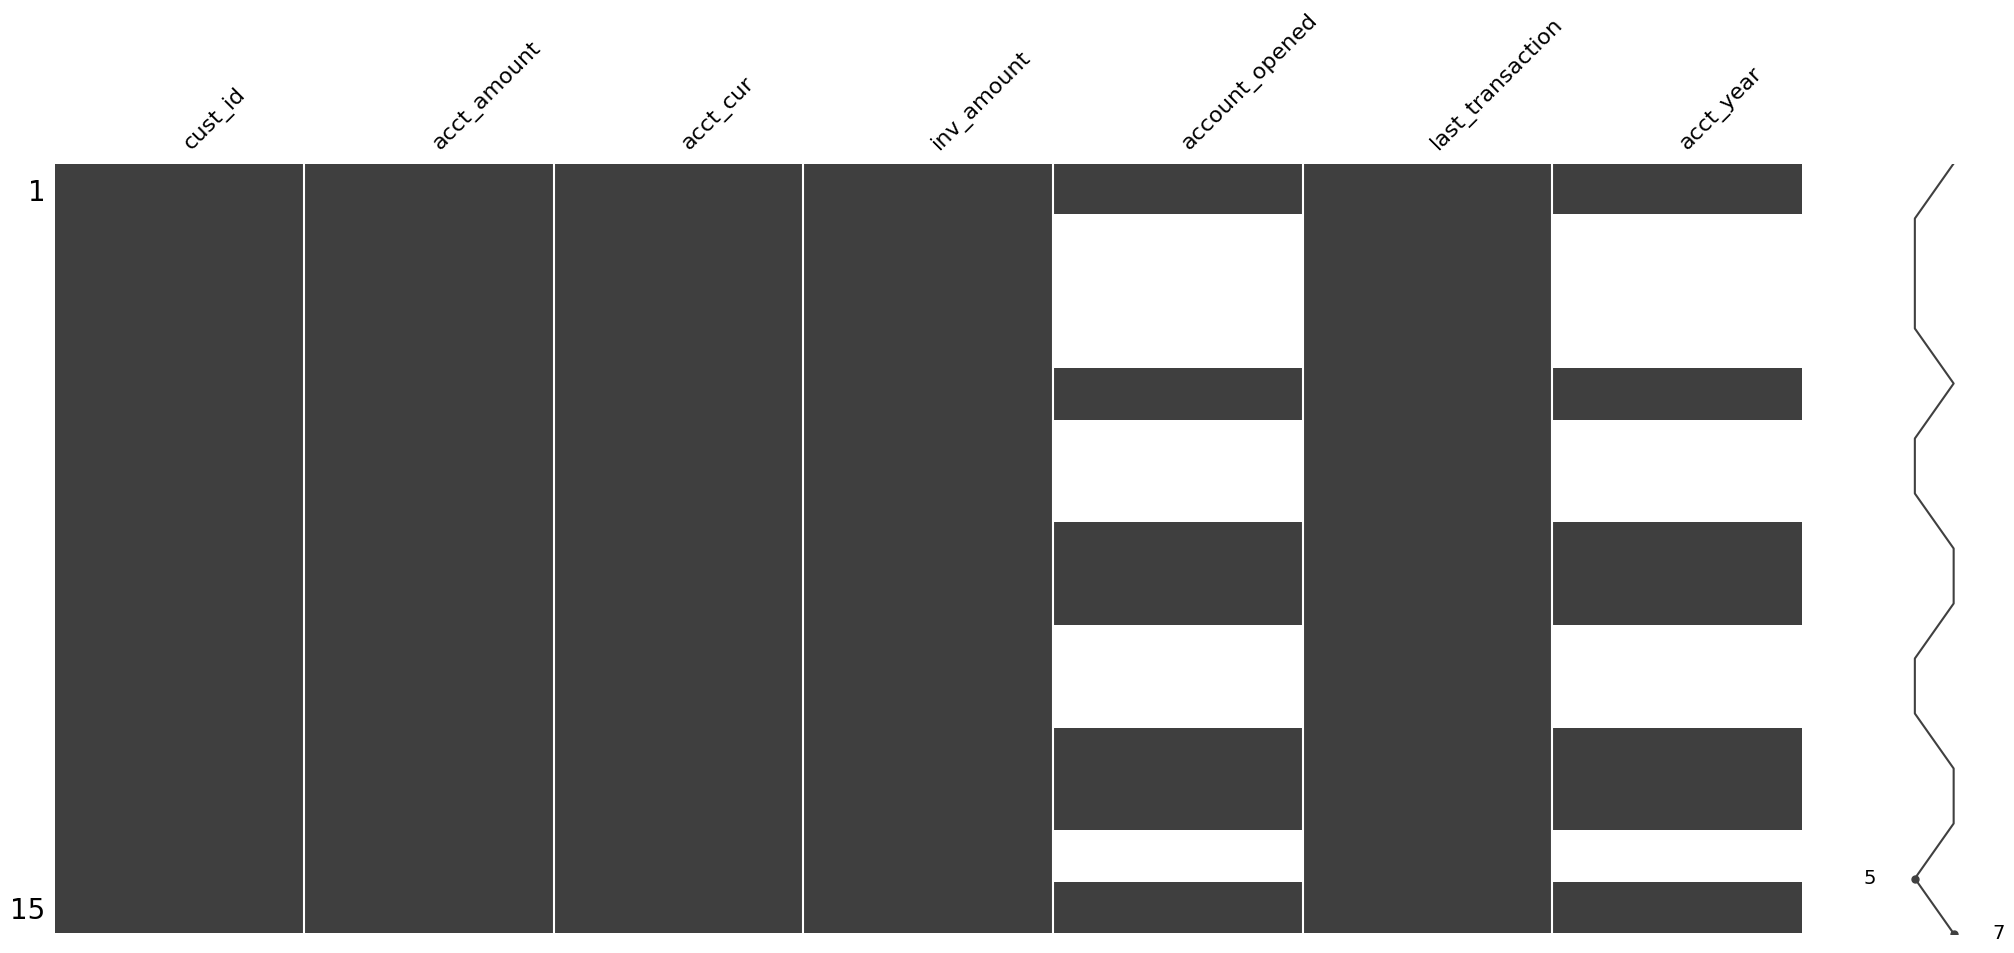

In [95]:
print(banking.isna().sum())

msno.matrix(banking)
plt.show()

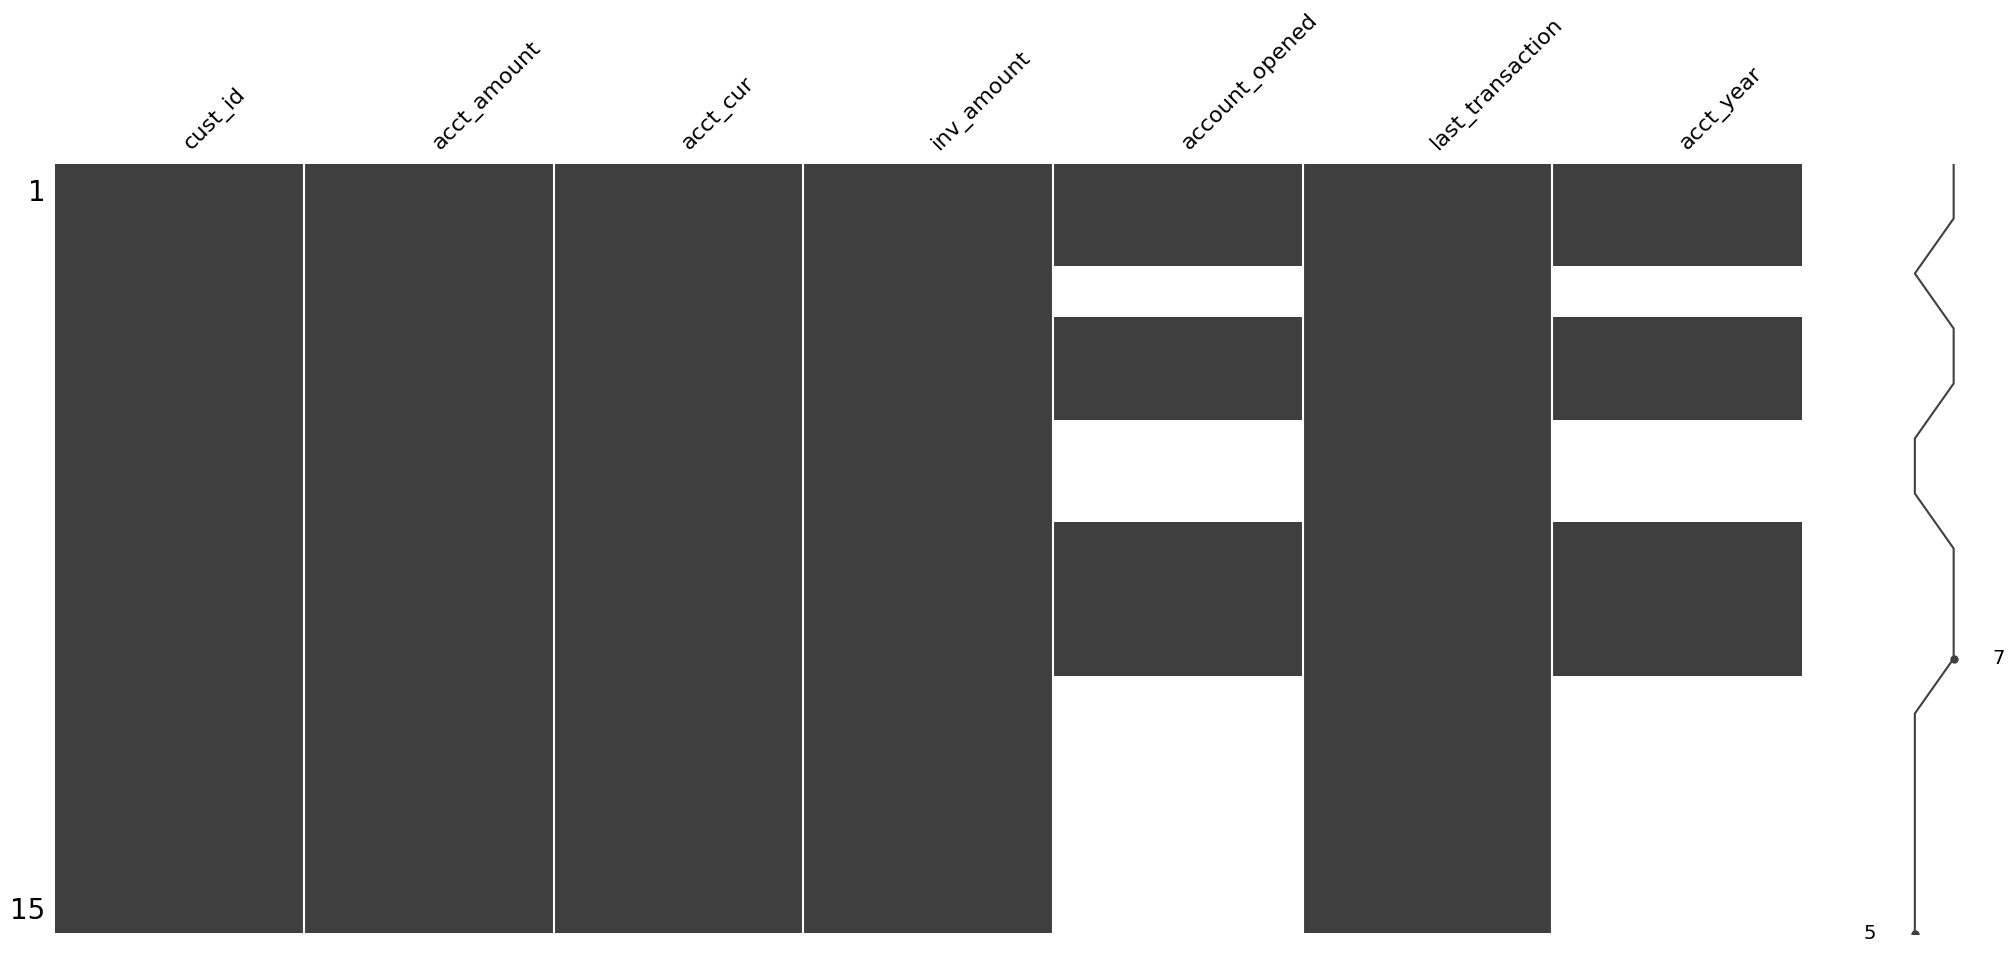

In [98]:
banking_sorted = banking.sort_values(by ='inv_amount')
msno.matrix(banking_sorted)
plt.show()

In [99]:
banking_fullid = banking.dropna(subset=["cust_id"])
acct_imp = banking_fullid["inv_amount"] * 5
banking_imputed = banking_fullid.fillna({'acct_amount': acct_imp})
banking_imputed.isna().sum()

cust_id             0
acct_amount         0
acct_cur            0
inv_amount          0
account_opened      8
last_transaction    0
acct_year           8
dtype: int64

## 4. Record linkage

### Comparing strings

In [104]:
from fuzzywuzzy import fuzz

In [105]:
fuzz.WRatio('Reeding', 'Reading')

86

In [106]:
fuzz.WRatio('Houston Rockets','Rockets')

90

In [107]:
from fuzzywuzzy import process

In [113]:
string = "Houston Rockets vs Los Angeles Lakers"
choices = pd.Series(['Rockets vs Lakers','Lakers vs Rockets','Houson vs Los Angeles','Heat vs Bulls'])
process.extract(string, choices, limit = 4)

[('Rockets vs Lakers', 86, 0),
 ('Lakers vs Rockets', 86, 1),
 ('Houson vs Los Angeles', 86, 2),
 ('Heat vs Bulls', 86, 3)]

In [114]:
restaurants.head()

,name,addr,city,phone,type
0,kokomo,6333 w. third st.,la,2139330773,american
1,feenix,8358 sunset blvd. west,hollywood,2138486677,american
2,parkway,510 s. arroyo pkwy .,pasadena,8187951001,californian
3,r-23,923 e. third st.,los angeles,2136877178,japanese
4,gumbo,6333 w. third st.,la,2139330358,cajun/creole


In [120]:
unique_types = restaurants["type"].unique()
process.extract('food', unique_types, limit = len(unique_types))

[('seafood', 90),
 ('health food', 90),
 ('fast food', 90),
 ('noodle shops', 68),
 ('californian', 45),
 ('hot dogs', 33),
 ('coffee shops', 25),
 ('southern/soul', 24),
 ('cajun/creole', 22),
 ('diners', 22),
 ('delis', 22),
 ('steakhouses', 22),
 ('middle eastern', 22),
 ('pacific new wave', 22),
 ('indonesian', 22),
 ('coffeebar', 22),
 ('continental', 22),
 ('french ( new )', 22),
 ('desserts', 22),
 ('american', 0),
 ('japanese', 0),
 ('hamburgers', 0),
 ('italian', 0),
 ('russian', 0),
 ('mexican/tex-mex', 0),
 ('mexican', 0),
 ('asian', 0),
 ('vietnamese', 0),
 ('american ( new )', 0),
 ('eclectic', 0),
 ('chicken', 0),
 ('chinese', 0),
 ('pizza', 0)]

In [127]:
process.extract('italian', restaurants['type'], limit = len(restaurants['type']))[:7]


[('italian', 100, 14),
 ('italian', 100, 21),
 ('italian', 100, 47),
 ('italian', 100, 57),
 ('italian', 100, 73),
 ('italian', 100, 75),
 ('italian', 100, 76)]

In [140]:
for cuisine in categoriesRestaurant:  
    matches = process.extract(cuisine, restaurants['type'], limit=len(restaurants.type))
    for match in matches:
        if match[1] >= 80:
            restaurants.loc[restaurants['type'] == match[0]] = cuisine
print(restaurants['type'].unique())

['american' 'californian' 'japanese' 'cajun/creole' 'hot dogs' 'diners'
 'delis' 'hamburgers' 'seafood' 'italian' 'coffee shops' 'russian'
 'steakhouses' 'mexican/tex-mex' 'noodle shops' 'middle eastern' 'asian'
 'vietnamese' 'health food' 'pacific new wave' 'indonesian' 'eclectic'
 'chicken' 'fast food' 'southern/soul' 'coffeebar' 'continental'
 'french ( new )' 'desserts' 'chinese' 'pizza']
